In [2]:
import numpy as np

import datetime
import io
import os
import random

import matplotlib.pyplot as plt

from sklearn.neighbors.kde import KernelDensity

%matplotlib inline

In [3]:
%run ../crowd/data.py
%run ../crowd/config.py
%run ../crowd/file_util.py
%run ../crowd/graph.py
%run ../crowd/topic.py

In [4]:
id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)

# This reads all the ground truth (GT) data.
test_data = read_all_test_labels()

In [5]:
def cosine_sims(topic_id):
    # Currently unused.
    fulltext_folder = FULLTEXT_FOLDER
    _, corpus = get_topic_files(fulltext_folder, topic_id)

    vectorizer = TfidfVectorizer(min_df=1)
    term_doc_matrix = vectorizer.fit_transform([text for doc_id, text in corpus])
    similarities = cosine_similarity(term_doc_matrix)
    flat_sim = similarities.reshape((-1, 1))
    flat_sim.shape

In [6]:
def count_votes(votes):
    relevant_votes = 0
    non_relevant_votes = 0
    for vote in votes:
        if vote.is_relevant > 0:
            relevant_votes += 1
        else:
            non_relevant_votes += 1
    
    return relevant_votes, non_relevant_votes


def get_all_vote_results(judgements):
    judgements_by_doc_id = get_all_judgements_by_doc_id(judgements)
    return get_vote_results_from_map(judgements_by_doc_id)

def get_topic_vote_results(topic_id, judgements):
    judgements_by_doc_id = get_topic_judgements_by_doc_id(topic_id, judgements)
    return get_vote_results_from_map(judgements_by_doc_id)

def get_vote_results_from_map(judgements_by_doc_id):
    """Helper function.
    
    Used by 'get_all_vote_results' and 'get_topic_vote_results'.
    """
    vote_relevant = set()
    vote_non_relevant = set()
    for doc_id, judgements in judgements_by_doc_id.items():
        rel_votes, non_rel_votes = count_votes(judgements)
        if rel_votes > non_rel_votes:
            vote_relevant.add(doc_id)
        elif rel_votes < non_rel_votes:
            vote_non_relevant.add(doc_id)
            
    return vote_relevant, vote_non_relevant

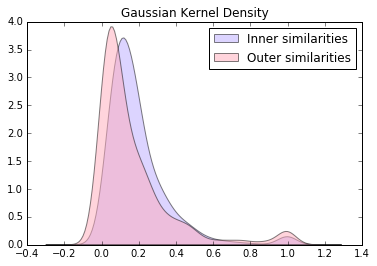

In [7]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

options={"[%s] %s (%d)" % (t.topic_id, t.query, t.document_count) : t.topic_id for t in id_topic_info.values()}

def similarity_list(document_texts):
    """Takes all the pairwise similarities between the given documents'
    tf-idf representations, and returns them in a column vector."""
    vectorizer = TfidfVectorizer(min_df=1)
    return cosine_similarity(vectorizer.fit_transform(document_texts)).reshape(-1, 1)


def kde(document_texts, **kw):
    bandwidth = kw.get('bandwidth', 0.05)
    similarities = similarity_list(document_texts)
    return KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(similarities)
    
    
def topic_rel(topic_id):
    gt_rel, gt_non_rel = get_relevant(topic_id, test_data)
    vote_rel, vote_non_rel = get_topic_vote_results(topic_id, judgements)
    _, corpus = get_topic_files(FULLTEXT_FOLDER, topic_id)
    rel_doc_texts = [text for doc_id, text in corpus 
                     if doc_id in gt_rel or doc_id in vote_rel]
#                      if doc_id in vote_rel]
    non_rel_doc_texts = [text for doc_id, text in corpus
                         if doc_id in gt_non_rel or doc_id in vote_non_rel]
#                          if doc_id in vote_non_relevant]
    return rel_doc_texts, non_rel_doc_texts


@interact(topic_id=options)
def topic_sim_kde(topic_id):
#     gt_relevant, gt_non_relevant = get_relevant(topic_id, test_data)
#     vote_relevant, vote_non_relevant = get_topic_vote_results(topic_id, judgements)
#     _, corpus = get_topic_files(FULLTEXT_FOLDER, topic_id)

    rel_doc_texts, non_rel_doc_texts = topic_rel(topic_id)
    
    bandwidth = 0.05
    X_plot = np.arange(-0.3, 1.3, 0.01).reshape(-1, 1)
    #kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(flat_sim)
    #log_dens = kde.score_samples(X_plot)

    kde_inner = kde(rel_doc_texts, bandwidth=bandwidth)
    log_dens_inner = kde_inner.score_samples(X_plot)
    kde_outer = kde(non_rel_doc_texts, bandwidth=bandwidth)
    log_dens_outer = kde_outer.score_samples(X_plot)

    #plt.hist(flat_sim, bins=15, color="green", alpha=0.5, normed=True)
    #plt.fill(X_plot, np.exp(log_dens), fc='#AAAAFF', alpha=0.5)
    plt.title("Gaussian Kernel Density")

    plt.fill(X_plot, np.exp(log_dens_inner), fc='#BBAAFF', alpha=0.5, label="Inner similarities")
    plt.fill(X_plot, np.exp(log_dens_outer), fc='#FFAABB', alpha=0.5, label="Outer similarities")
    plt.legend()

Bad ones (overlap): orlando sentinel, elvish language (a little), diy audio, earthquake (!).
One in paper: 20542 how does the fly pentop computer work

# Aggregate KDE

In [8]:
gt_relevant, gt_non_relevant = get_all_relevant(test_data)
vote_relevant, vote_non_relevant = get_all_vote_results(judgements)
_, corpus = get_all_files(FULLTEXT_FOLDER)

print(corpus[0][0])

clueweb09-en0000-05-22942


In [42]:
rel_doc_texts = [text for doc_id, text in corpus 
                 if doc_id in gt_relevant or doc_id in vote_relevant]
non_rel_doc_texts = [text for doc_id, text in corpus
                     if doc_id in gt_non_relevant or doc_id in vote_non_relevant]

vectorizer = TfidfVectorizer(min_df=1)
rel_similarities = cosine_similarity(vectorizer.fit_transform(rel_doc_texts))
non_rel_similarities = cosine_similarity(vectorizer.fit_transform(non_rel_doc_texts))

In [71]:
topic_ids = id_topic_info.values()
all_topic_rel_non_rel = [topic_rel(t.topic_id) for t in topic_ids]

In [97]:
all_rel_sim = [similarity_list(rel_non_rel[0])[:, 0] for rel_non_rel in all_topic_rel_non_rel]
all_non_rel_sim = [similarity_list(rel_non_rel[1])[:, 0] for rel_non_rel in all_topic_rel_non_rel]

In [77]:
print(all_rel_sim[0].shape)
print(np.histogram(all_rel_sim[0]))

(2704,)
(array([846, 634, 548, 348, 180,  70,   6,   6,   6,  60]), array([  7.48423901e-04,   1.00673582e-01,   2.00598739e-01,
         3.00523897e-01,   4.00449054e-01,   5.00374212e-01,
         6.00299370e-01,   7.00224527e-01,   8.00149685e-01,
         9.00074842e-01,   1.00000000e+00]))


In [104]:
# The [1] is because 'np.histogram' doesn't just return the histogram! (See docs)
BIN_COUNT = 50
all_rel_hist = [np.histogram(rs, bins=BIN_COUNT)[0] for rs in all_rel_sim]
all_rel_hist = np.array(all_rel_hist)

all_non_rel_hist = [np.histogram(rs, bins=BIN_COUNT)[0] for rs in all_non_rel_sim]
all_non_rel_hist = np.array(all_non_rel_hist)

In [105]:
print(all_rel_hist.shape)
print(all_non_rel_hist.shape)

(30, 50)
(30, 50)


In [106]:
all_rel_hist_avg = np.mean(all_rel_hist, axis=0)
all_non_rel_hist_avg = np.mean(all_non_rel_hist, axis=0)

In [1]:
plt.bar(np.linspace(0, 1, all_rel_hist_avg.shape[0]), all_rel_hist_avg, width=1/all_rel_hist_avg.shape[0])
plt.title("Hacky inner similarity histogram")

NameError: name 'plt' is not defined

<Container object of 50 artists>

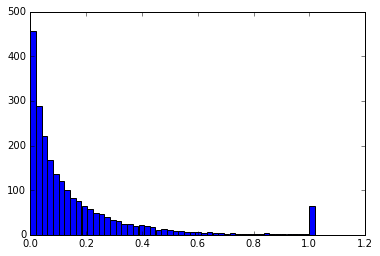

In [108]:
plt.bar(np.linspace(0, 1, all_non_rel_hist_avg.shape[0]), all_non_rel_hist_avg, width=1/all_non_rel_hist_avg.shape[0])

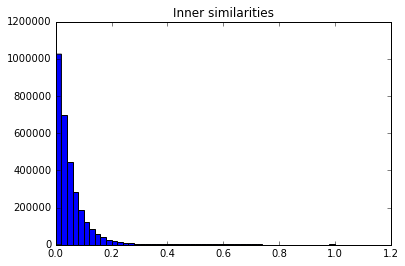

In [39]:
_ = plt.hist(rel_similarities.reshape(-1, 1), 50)
plt.title("Inner similarities")

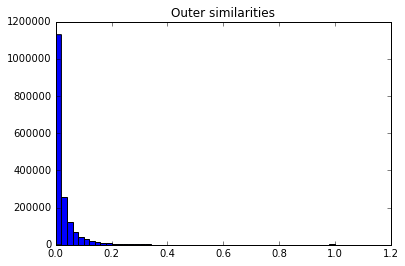

In [41]:
_ = plt.hist(non_rel_similarities.reshape(-1, 1), 50)
plt.title("Outer similarities")

Computing inner KDE.
Computing outer KDE.
Plotting...
Finished.


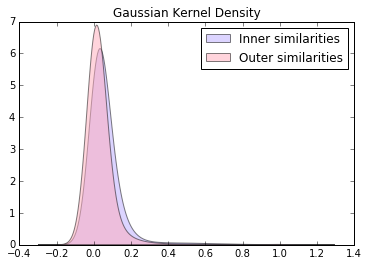

In [19]:
rel_doc_texts = [text for doc_id, text in corpus 
                 if doc_id in gt_relevant or doc_id in vote_relevant]
non_rel_doc_texts = [text for doc_id, text in corpus
                     if doc_id in gt_non_relevant or doc_id in vote_non_relevant]

bandwidth = 0.05
X_plot = np.arange(-0.3, 1.3, 0.005).reshape(-1, 1)
#kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(flat_sim)
#log_dens = kde.score_samples(X_plot)

print("Computing inner KDE.")
kde_inner = kde(rel_doc_texts)
log_dens_inner = kde_inner.score_samples(X_plot)

print("Computing outer KDE.")
kde_outer = kde(non_rel_doc_texts)
log_dens_outer = kde_outer.score_samples(X_plot)

#plt.hist(flat_sim, bins=15, color="green", alpha=0.5, normed=True)
#plt.fill(X_plot, np.exp(log_dens), fc='#AAAAFF', alpha=0.5)
plt.title("Gaussian Kernel Density")

print("Plotting...")
plt.fill(X_plot, np.exp(log_dens_inner), fc='#BBAAFF', alpha=0.5, label="Inner similarities")
plt.fill(X_plot, np.exp(log_dens_outer), fc='#FFAABB', alpha=0.5, label="Outer similarities")
plt.legend()
print("Finished.")
